Inspired by https://f1metrics.wordpress.com/2014/10/03/building-a-race-simulator/



In [1]:
import fastf1 as ff1
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from race import *
from constants import *
from practice import *
from scipy import stats

# Enable the cache by providing the name of the cache folder
ff1.Cache.enable_cache('cache')

In [2]:
DRIVER = 'VER'

#### FP2

In [3]:
FP2 = ff1.get_session(2022, 'Hungary', 'FP2')
FP2.load()

core           INFO 	Loading data for Hungarian Grand Prix - Practice 2 [v2.2.9]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '55', '47', '44', '31', '24', '23', '22', '20', '18', '16', '14', '11', '10', '6', '5', '4', '3', '63', '77']


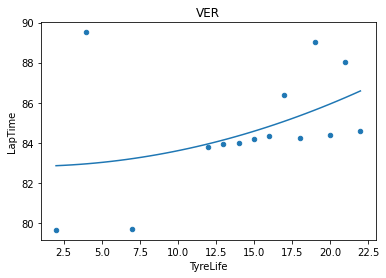

In [4]:
# Only pick representative laps - laps that are set under green flag and not in/out laps
fp2_representative_laps = FP2.laps.pick_driver(DRIVER).pick_accurate().pick_wo_box().pick_track_status('1')

# Convert laptime from timedelta to seconds for plotting
convert_laptime_to_seconds(fp2_representative_laps)

# Consider only medium
fp2_representative_laps_medium = fp2_representative_laps.pick_tyre(MEDIUM)

remove_outlier_laps(fp2_representative_laps_medium)

model = get_tyre_model(fp2_representative_laps_medium)

subplot = plot_tyre_model(fp2_representative_laps_medium, model)

C:\Users\chun\AppData\Local\Temp\ipykernel_7272\1307440698.py:27: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


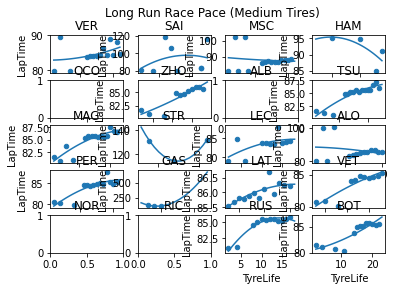

In [25]:
fig, axs = plt.subplots(5, 4)
fig.suptitle('Long Run Race Pace (Medium Tires)')

drivers = get_all_driver_names(FP2.laps)
for i in range(len(drivers)):
    # Only pick representative laps - laps that are set under green flag and not in/out laps
    fp2_representative_laps = FP2.laps.pick_driver(drivers[i]).pick_accurate().pick_wo_box().pick_track_status('1')

    # Convert laptime from timedelta to seconds for plotting
    convert_laptime_to_seconds(fp2_representative_laps)

    # Consider only medium
    fp2_representative_laps_medium = fp2_representative_laps.pick_tyre(MEDIUM)

    remove_outlier_laps(fp2_representative_laps_medium)

    # Todo: remove try-excepts
    try:
        model = get_tyre_model(fp2_representative_laps_medium)
        subplot = plot_tyre_model(fp2_representative_laps_medium, model, axs, i//4, i%4)
    except:
        try:
            subplot = plot_tyre_model(fp2_representative_laps_medium, None, axs, i//4, i%4)
        except:
            axs[i//4, i%4].title.set_text(drivers[i])
            
 
    
    
    
    

    

In [21]:
drivers

['VER',
 'SAI',
 'MSC',
 'HAM',
 'OCO',
 'ZHO',
 'ALB',
 'TSU',
 'MAG',
 'STR',
 'LEC',
 'ALO',
 'PER',
 'GAS',
 'LAT',
 'VET',
 'NOR',
 'RIC',
 'RUS',
 'BOT']

#### Race

In [6]:
grand_prix = ff1.get_session(2022, 'Hungary', 'R')
grand_prix.load()

core           INFO 	Loading data for Hungarian Grand Prix - Race [v2.2.9]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '63', '55', '11', '16', '4', '14', '31', '5', '18', '10', '24', '47', '3', '20', '23', '6', '22', '77']


In [7]:
grand_prix.laps.head()

,Time,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,Sector3Time,...,IsPersonalBest,Compound,TyreLife,FreshTyre,LapStartTime,Team,Driver,TrackStatus,IsAccurate,LapStartDate
0,0 days 01:03:42.565000,1,NaT,1,1,0 days 00:26:07.764000,NaT,NaT,0 days 00:00:32.843000,0 days 00:00:26.532000,...,False,SOFT,2.0,False,0 days 01:02:05.807000,Red Bull Racing,VER,26,False,2022-07-31 13:03:06.185
1,0 days 01:05:37.025000,1,0 days 00:01:54.460000,2,1,NaT,NaT,0 days 00:00:48.472000,0 days 00:00:33.956000,0 days 00:00:32.032000,...,False,SOFT,3.0,False,0 days 01:03:42.565000,Red Bull Racing,VER,6,False,2022-07-31 13:04:42.943
2,0 days 01:07:05.216000,1,0 days 00:01:28.191000,3,1,NaT,NaT,0 days 00:00:33.699000,0 days 00:00:30.743000,0 days 00:00:23.749000,...,False,SOFT,4.0,False,0 days 01:05:37.025000,Red Bull Racing,VER,67,False,2022-07-31 13:06:37.403
3,0 days 01:08:30.274000,1,0 days 00:01:25.058000,4,1,NaT,NaT,0 days 00:00:30.148000,0 days 00:00:31.114000,0 days 00:00:23.796000,...,False,SOFT,5.0,False,0 days 01:07:05.216000,Red Bull Racing,VER,1,True,2022-07-31 13:08:05.594
4,0 days 01:09:54.395000,1,0 days 00:01:24.121000,5,1,NaT,NaT,0 days 00:00:29.811000,0 days 00:00:30.698000,0 days 00:00:23.612000,...,False,SOFT,6.0,False,0 days 01:08:30.274000,Red Bull Racing,VER,1,True,2022-07-31 13:09:30.652


In [8]:
grand_prix.laps.pick_fastest()

Time                      0 days 02:23:16.305000
DriverNumber                                  44
LapTime                   0 days 00:01:21.386000
LapNumber                                     57
Stint                                          3
PitOutTime                                   NaT
PitInTime                                    NaT
Sector1Time               0 days 00:00:29.277000
Sector2Time               0 days 00:00:29.402000
Sector3Time               0 days 00:00:22.707000
Sector1SessionTime        0 days 02:22:24.196000
Sector2SessionTime        0 days 02:22:53.598000
Sector3SessionTime        0 days 02:23:16.305000
SpeedI1                                    276.0
SpeedI2                                    240.0
SpeedFL                                    244.0
SpeedST                                    280.0
IsPersonalBest                              True
Compound                                    SOFT
TyreLife                                     8.0
FreshTyre           

In [9]:
grand_prix.laps.LapTime.describe()

count                         1362
mean     0 days 00:01:26.459262848
std      0 days 00:00:05.886114986
min         0 days 00:01:21.386000
25%         0 days 00:01:23.954250
50%         0 days 00:01:24.995000
75%         0 days 00:01:25.896250
max         0 days 00:02:03.576000
Name: LapTime, dtype: object

In [10]:
race_laps = grand_prix.laps

In [11]:
laps = race_laps.pick_driver(DRIVER)
laps.head()

,Time,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,Sector3Time,...,IsPersonalBest,Compound,TyreLife,FreshTyre,LapStartTime,Team,Driver,TrackStatus,IsAccurate,LapStartDate
0,0 days 01:03:42.565000,1,NaT,1,1,0 days 00:26:07.764000,NaT,NaT,0 days 00:00:32.843000,0 days 00:00:26.532000,...,False,SOFT,2.0,False,0 days 01:02:05.807000,Red Bull Racing,VER,26,False,2022-07-31 13:03:06.185
1,0 days 01:05:37.025000,1,0 days 00:01:54.460000,2,1,NaT,NaT,0 days 00:00:48.472000,0 days 00:00:33.956000,0 days 00:00:32.032000,...,False,SOFT,3.0,False,0 days 01:03:42.565000,Red Bull Racing,VER,6,False,2022-07-31 13:04:42.943
2,0 days 01:07:05.216000,1,0 days 00:01:28.191000,3,1,NaT,NaT,0 days 00:00:33.699000,0 days 00:00:30.743000,0 days 00:00:23.749000,...,False,SOFT,4.0,False,0 days 01:05:37.025000,Red Bull Racing,VER,67,False,2022-07-31 13:06:37.403
3,0 days 01:08:30.274000,1,0 days 00:01:25.058000,4,1,NaT,NaT,0 days 00:00:30.148000,0 days 00:00:31.114000,0 days 00:00:23.796000,...,False,SOFT,5.0,False,0 days 01:07:05.216000,Red Bull Racing,VER,1,True,2022-07-31 13:08:05.594
4,0 days 01:09:54.395000,1,0 days 00:01:24.121000,5,1,NaT,NaT,0 days 00:00:29.811000,0 days 00:00:30.698000,0 days 00:00:23.612000,...,False,SOFT,6.0,False,0 days 01:08:30.274000,Red Bull Racing,VER,1,True,2022-07-31 13:09:30.652


In [12]:
calculate_race_lap_times(laps)
laps.head()

,Time,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,Sector3Time,...,IsPersonalBest,Compound,TyreLife,FreshTyre,LapStartTime,Team,Driver,TrackStatus,IsAccurate,LapStartDate
0,0 days 01:03:42.565000,1,0 days 00:01:36.758000,1,1,0 days 00:26:07.764000,NaT,NaT,0 days 00:00:32.843000,0 days 00:00:26.532000,...,False,SOFT,2.0,False,0 days 01:02:05.807000,Red Bull Racing,VER,26,False,2022-07-31 13:03:06.185
1,0 days 01:05:37.025000,1,0 days 00:01:54.460000,2,1,NaT,NaT,0 days 00:00:48.472000,0 days 00:00:33.956000,0 days 00:00:32.032000,...,False,SOFT,3.0,False,0 days 01:03:42.565000,Red Bull Racing,VER,6,False,2022-07-31 13:04:42.943
2,0 days 01:07:05.216000,1,0 days 00:01:28.191000,3,1,NaT,NaT,0 days 00:00:33.699000,0 days 00:00:30.743000,0 days 00:00:23.749000,...,False,SOFT,4.0,False,0 days 01:05:37.025000,Red Bull Racing,VER,67,False,2022-07-31 13:06:37.403
3,0 days 01:08:30.274000,1,0 days 00:01:25.058000,4,1,NaT,NaT,0 days 00:00:30.148000,0 days 00:00:31.114000,0 days 00:00:23.796000,...,False,SOFT,5.0,False,0 days 01:07:05.216000,Red Bull Racing,VER,1,True,2022-07-31 13:08:05.594
4,0 days 01:09:54.395000,1,0 days 00:01:24.121000,5,1,NaT,NaT,0 days 00:00:29.811000,0 days 00:00:30.698000,0 days 00:00:23.612000,...,False,SOFT,6.0,False,0 days 01:08:30.274000,Red Bull Racing,VER,1,True,2022-07-31 13:09:30.652


In [13]:
convert_laptime_to_seconds(laps)
laps.head()

C:\Users\chun\PycharmProjects\formulaOneBeginner\race.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "LapTime"] = df["LapTime"].dt.total_seconds()


,Time,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,Sector3Time,...,IsPersonalBest,Compound,TyreLife,FreshTyre,LapStartTime,Team,Driver,TrackStatus,IsAccurate,LapStartDate
0,0 days 01:03:42.565000,1,96.758,1,1,0 days 00:26:07.764000,NaT,NaT,0 days 00:00:32.843000,0 days 00:00:26.532000,...,False,SOFT,2.0,False,0 days 01:02:05.807000,Red Bull Racing,VER,26,False,2022-07-31 13:03:06.185
1,0 days 01:05:37.025000,1,114.460,2,1,NaT,NaT,0 days 00:00:48.472000,0 days 00:00:33.956000,0 days 00:00:32.032000,...,False,SOFT,3.0,False,0 days 01:03:42.565000,Red Bull Racing,VER,6,False,2022-07-31 13:04:42.943
2,0 days 01:07:05.216000,1,88.191,3,1,NaT,NaT,0 days 00:00:33.699000,0 days 00:00:30.743000,0 days 00:00:23.749000,...,False,SOFT,4.0,False,0 days 01:05:37.025000,Red Bull Racing,VER,67,False,2022-07-31 13:06:37.403
3,0 days 01:08:30.274000,1,85.058,4,1,NaT,NaT,0 days 00:00:30.148000,0 days 00:00:31.114000,0 days 00:00:23.796000,...,False,SOFT,5.0,False,0 days 01:07:05.216000,Red Bull Racing,VER,1,True,2022-07-31 13:08:05.594
4,0 days 01:09:54.395000,1,84.121,5,1,NaT,NaT,0 days 00:00:29.811000,0 days 00:00:30.698000,0 days 00:00:23.612000,...,False,SOFT,6.0,False,0 days 01:08:30.274000,Red Bull Racing,VER,1,True,2022-07-31 13:09:30.652


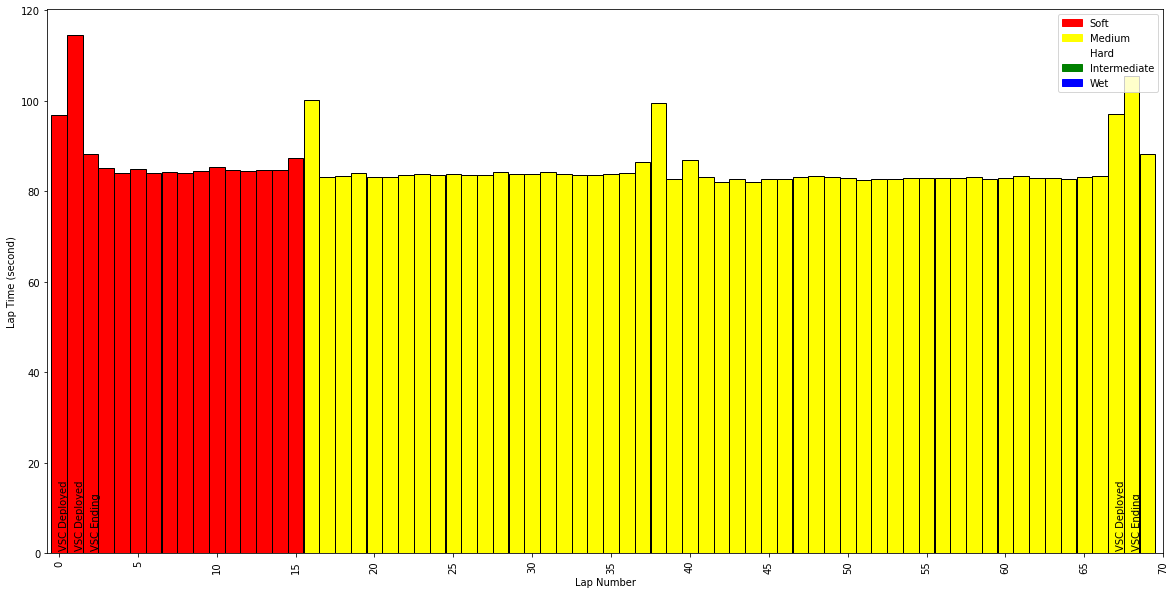

In [14]:
# Plot the graph
laptime_bar_graph = plot_lap_time_bar_graph(laps)


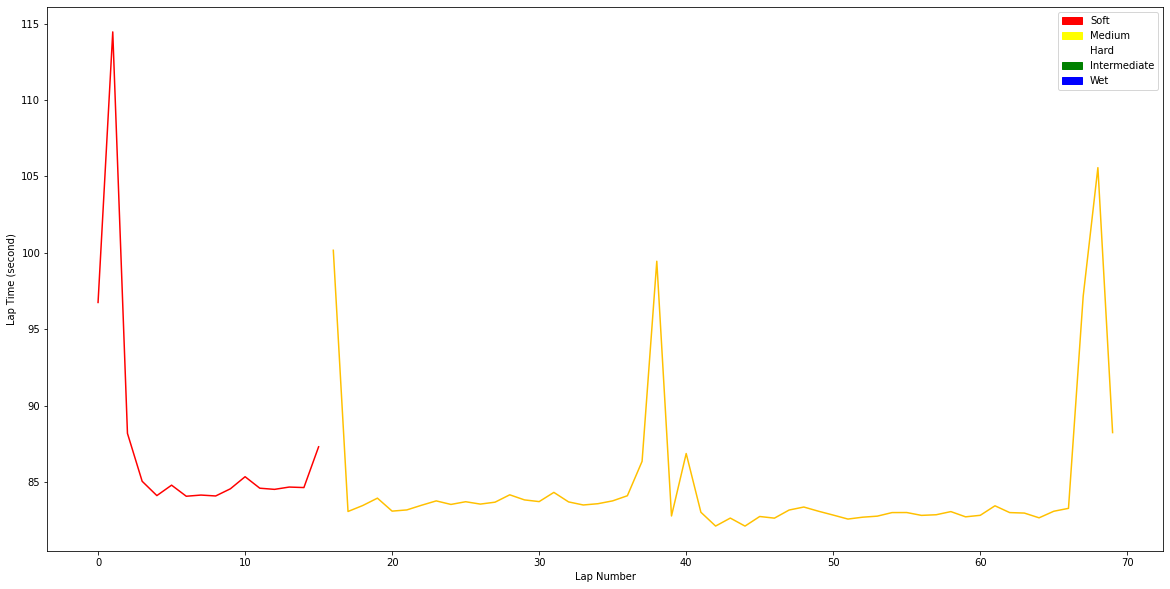

In [15]:
# Use the unstack function to separate the LapTime based on Compounds so we can plot by color later (by ignoring the NA values)
laptime_line_graph = plot_lap_time_line_graph(laps)